# Get deps and event

## Dependencies


In [138]:
from datetime import timedelta
import math
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)
ff1.Cache.enable_cache('./cache')

plotting.setup_mpl()

# Magyar, %-ban mennyi a pit-ben %-ban
# Hány km-t ment

session = ff1.get_session(2022, 'Dutch', 'R')
session.load()

<IPython.core.display.Javascript object>

## Config


In [139]:
tyreTypes = ["SOFT", "MEDIUM", "HARD"]

session = ff1.get_session(2022, 'Dutch', 'R')
session.load()

single_driver_name = 'LEC'
dual_driver_names = []
multiple_drivers = ["LAT", "LEC", "RUS", "VER"]
multiple_drivers.sort()

tyreTypes = ["SOFT", "MEDIUM", "HARD"]
tyreTypeColors = ["red", "yellow", "white"]

driverColors = []
concated_names  = ""
for x in multiple_drivers:
    concated_names += x+"_"
    driverColors.append(ff1.plotting.driver_color(x))

# Get base data for drivers

In [140]:

mixed_group = pd.DataFrame()
mixed_telemetry = pd.DataFrame()

for tyreType in tyreTypes:

    for driver_item in multiple_drivers:
        driver = session.laps.pick_driver(driver_item)
        
        bestLap = driver.pick_tyre(tyreType)
        bestLap = bestLap.sort_values(by=["LapTime"])
        bestLap = bestLap[0:1]
        
        for cLap in bestLap.iterlaps():
            driver_telemetry = cLap[1].get_car_data().add_distance()
            driver_telemetry["Driver"] = driver_item
            driver_telemetry["LapNumber"] = cLap[1]["LapNumber"]

            driver_telemetry["LapTime"] = cLap[1]["LapTime"]
            driver_telemetry["TyreLife"] = cLap[1]["TyreLife"]
            driver_telemetry["FreshTyre"] = cLap[1]["FreshTyre"]

            driver_telemetry['Compound'] = cLap[1]['Compound']

            mixed_telemetry = pd.concat([mixed_telemetry, driver_telemetry])

        mixed_group = pd.concat([mixed_group, bestLap])


mixed_group = mixed_group[["Driver", "LapTime", "LapNumber", "Compound", "TyreLife", "FreshTyre"]]
mixed_telemetry = mixed_telemetry[["Driver", "LapTime", "LapNumber", "Compound", "TyreLife", "FreshTyre", "Speed", "Distance"]]

avg_speed = mixed_telemetry.groupby(["Driver", "LapNumber", "LapTime", "Compound"])["Speed"].mean().reset_index().sort_values("Driver")

max_speed = mixed_telemetry.groupby(["Driver", "LapNumber", "LapTime", "Compound"])["Speed"].max().reset_index().sort_values("Driver")

min_speed = mixed_telemetry.groupby(["Driver", "LapNumber", "LapTime", "Compound"])["Speed"].min().reset_index().sort_values("Driver")

speeds_array = {
    "AVG":avg_speed,
    "MAX":max_speed,
    "MIN":min_speed
}

telemetries_by_compound = {
    "AVG":avg_speed,
    "MAX":max_speed,
    "MIN":min_speed
}

# Select the compound with the highest average speed
fastest_compounds = avg_speed.loc[avg_speed.groupby(['Driver'])['Speed'].idxmax()]

# Get rid of the speed column and rename the Compound column
fastest_compounds = fastest_compounds[['Driver', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})

# Single driver stats for tyre types

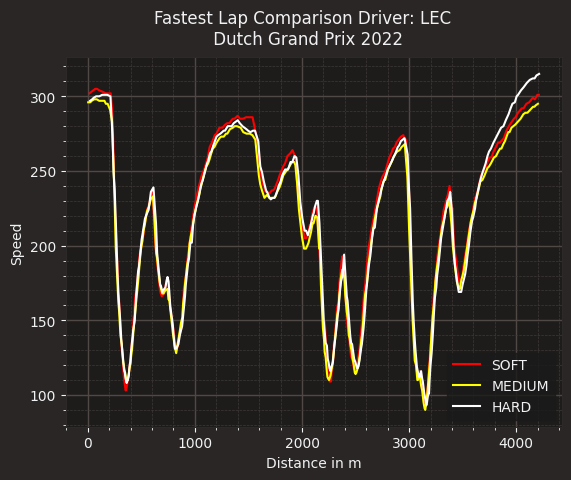

In [141]:
track_temperatures = session.weather_data.TrackTemp

fig, ax = plt.subplots()

tyreTypeIdx = 0
for tyreType in tyreTypes:
    singlge_driver_telemetry = mixed_telemetry[(mixed_telemetry.Compound == tyreType) & (mixed_telemetry.Driver == single_driver_name)]
    ax.plot(singlge_driver_telemetry['Distance'], singlge_driver_telemetry['Speed'], color=tyreTypeColors[tyreTypeIdx], label=tyreType)
    tyreTypeIdx = tyreTypeIdx + 1

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed')

ax.legend()
plt.Figure(dpi=1200)
plt.suptitle(f"Fastest Lap Comparison Driver: {single_driver_name} \n "
             f"{session.event['EventName']} {session.event.year}")
plt.show()
fig.set_dpi(1200)
fig.savefig(f"output/Tyres_{single_driver_name}.png", dpi=1200)

# Multiple driver stats for tyres

## Multiple drivers lap time by compound

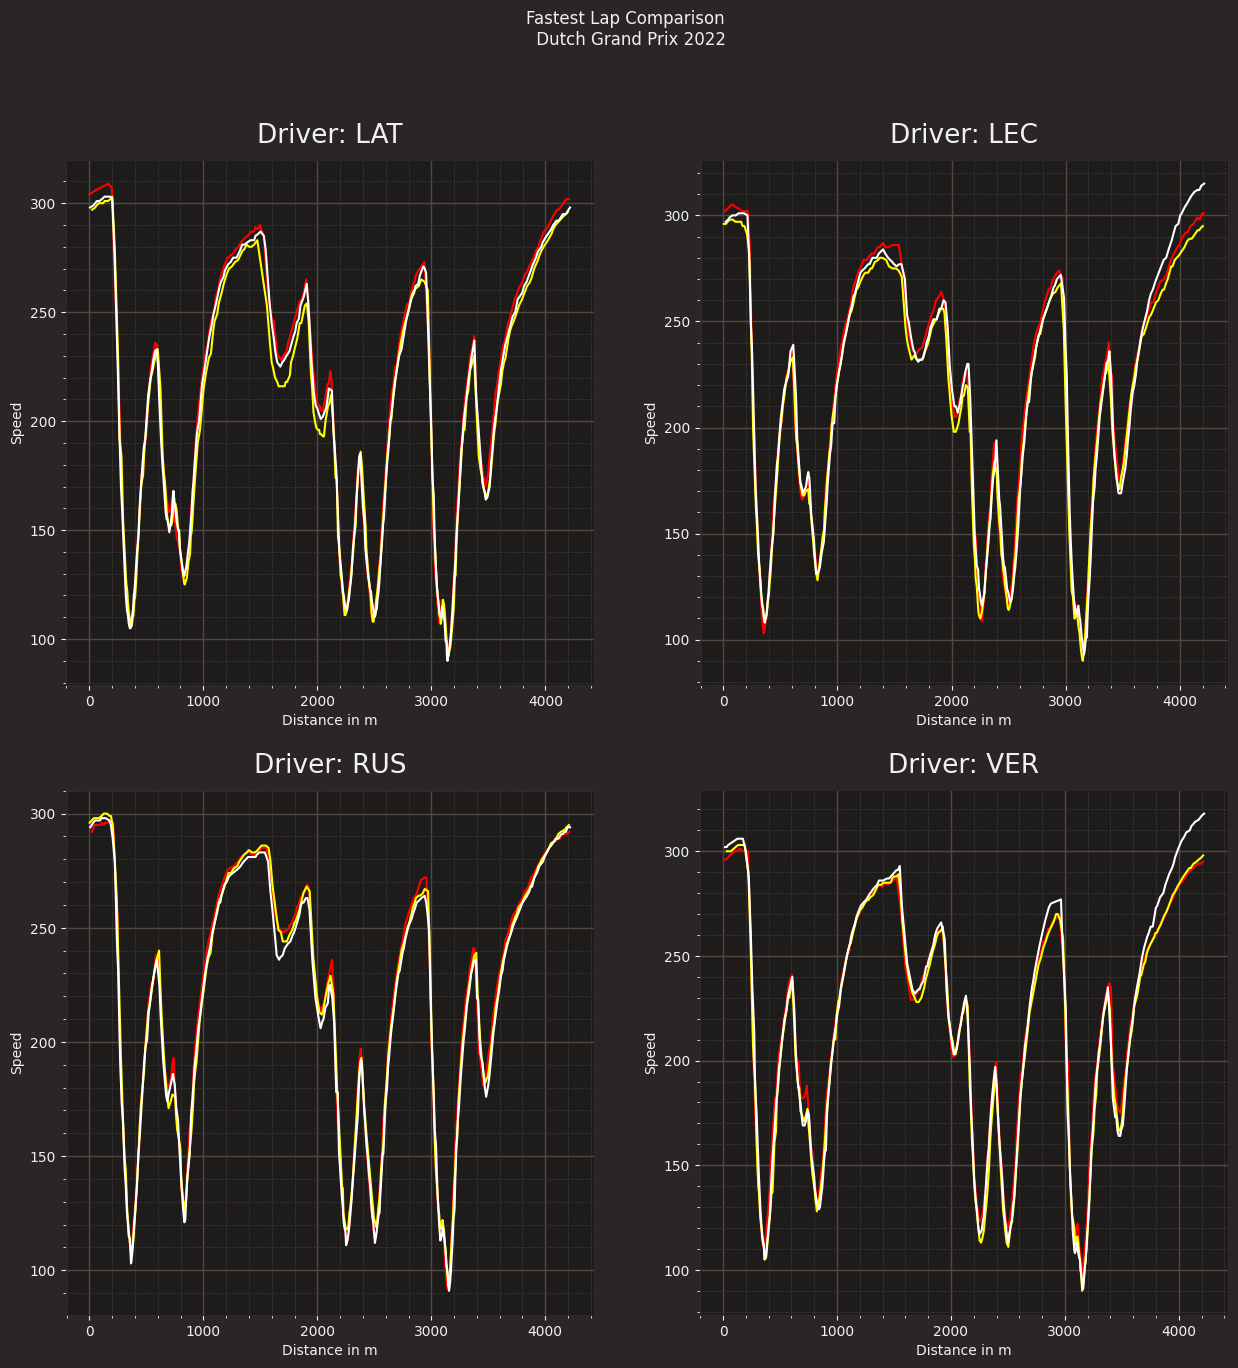

In [153]:
track_temperatures = session.weather_data.TrackTemp

fig, axs = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(15)
plotCoordX = 0
plotCoordY = 0
for driverName in multiple_drivers:
    tyreTypeIdx = 0
    for tyreType in tyreTypes:
        singlge_driver_telemetry = mixed_telemetry[(mixed_telemetry.Compound == tyreType) & (mixed_telemetry.Driver == driverName)]
        axs[plotCoordX, plotCoordY].plot(singlge_driver_telemetry['Distance'], singlge_driver_telemetry['Speed'], color=tyreTypeColors[tyreTypeIdx], label=tyreType)
        tyreTypeIdx = tyreTypeIdx + 1

    axs[plotCoordX, plotCoordY].set_xlabel('Distance in m')
    axs[plotCoordX, plotCoordY].set_ylabel('Speed')

    #axs[plotCoordX, plotCoordY].legend()
    axs[plotCoordX, plotCoordY].set_title(f"Driver: {driverName}")

    if plotCoordX == 0 and plotCoordY == 0:
        plotCoordY = 1
    elif plotCoordX == 0 and plotCoordY == 1:
        plotCoordX = 1
        plotCoordY = 0
    elif plotCoordX == 1 and plotCoordY == 0:
        plotCoordX = 1
        plotCoordY = 1

plt.suptitle(f"Fastest Lap Comparison \n {session.event['EventName']} {session.event.year}")
plt.show()
plt.Figure(dpi=1200)
fig.set_dpi(1200)
fig.savefig(f"output/Multiple_laptime_by_compound_{concated_names}.png", dpi=1200)

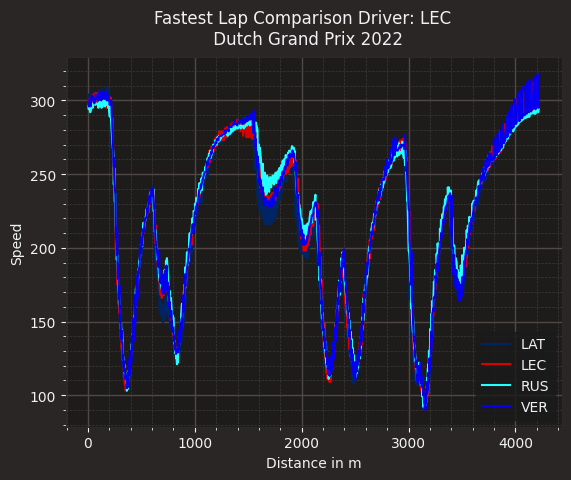

In [179]:

fig, ax = plt.subplots()

full_avg = mixed_telemetry.groupby(["Driver", "Distance"])["Speed"].mean().reset_index().sort_values(["Distance","Driver"])

tyreTypeIdx = 0
for driverName in multiple_drivers:
    singlge_driver_telemetry = full_avg[full_avg.Driver == driverName]
    ax.plot(singlge_driver_telemetry['Distance'], singlge_driver_telemetry['Speed'], color=driverColors[tyreTypeIdx], label=driverName)
    tyreTypeIdx = tyreTypeIdx + 1

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed')

ax.legend()
plt.Figure(dpi=1200)
plt.suptitle(f"Fastest Lap Comparison Driver: {single_driver_name} \n "
             f"{session.event['EventName']} {session.event.year}")
plt.show()
fig.set_dpi(1200)
fig.set_figwidth(15)
fig.set_figheight(15)
fig.savefig(f"output/Tyres_{single_driver_name}.png", dpi=1200)

## AVG, MIN, MAX charts

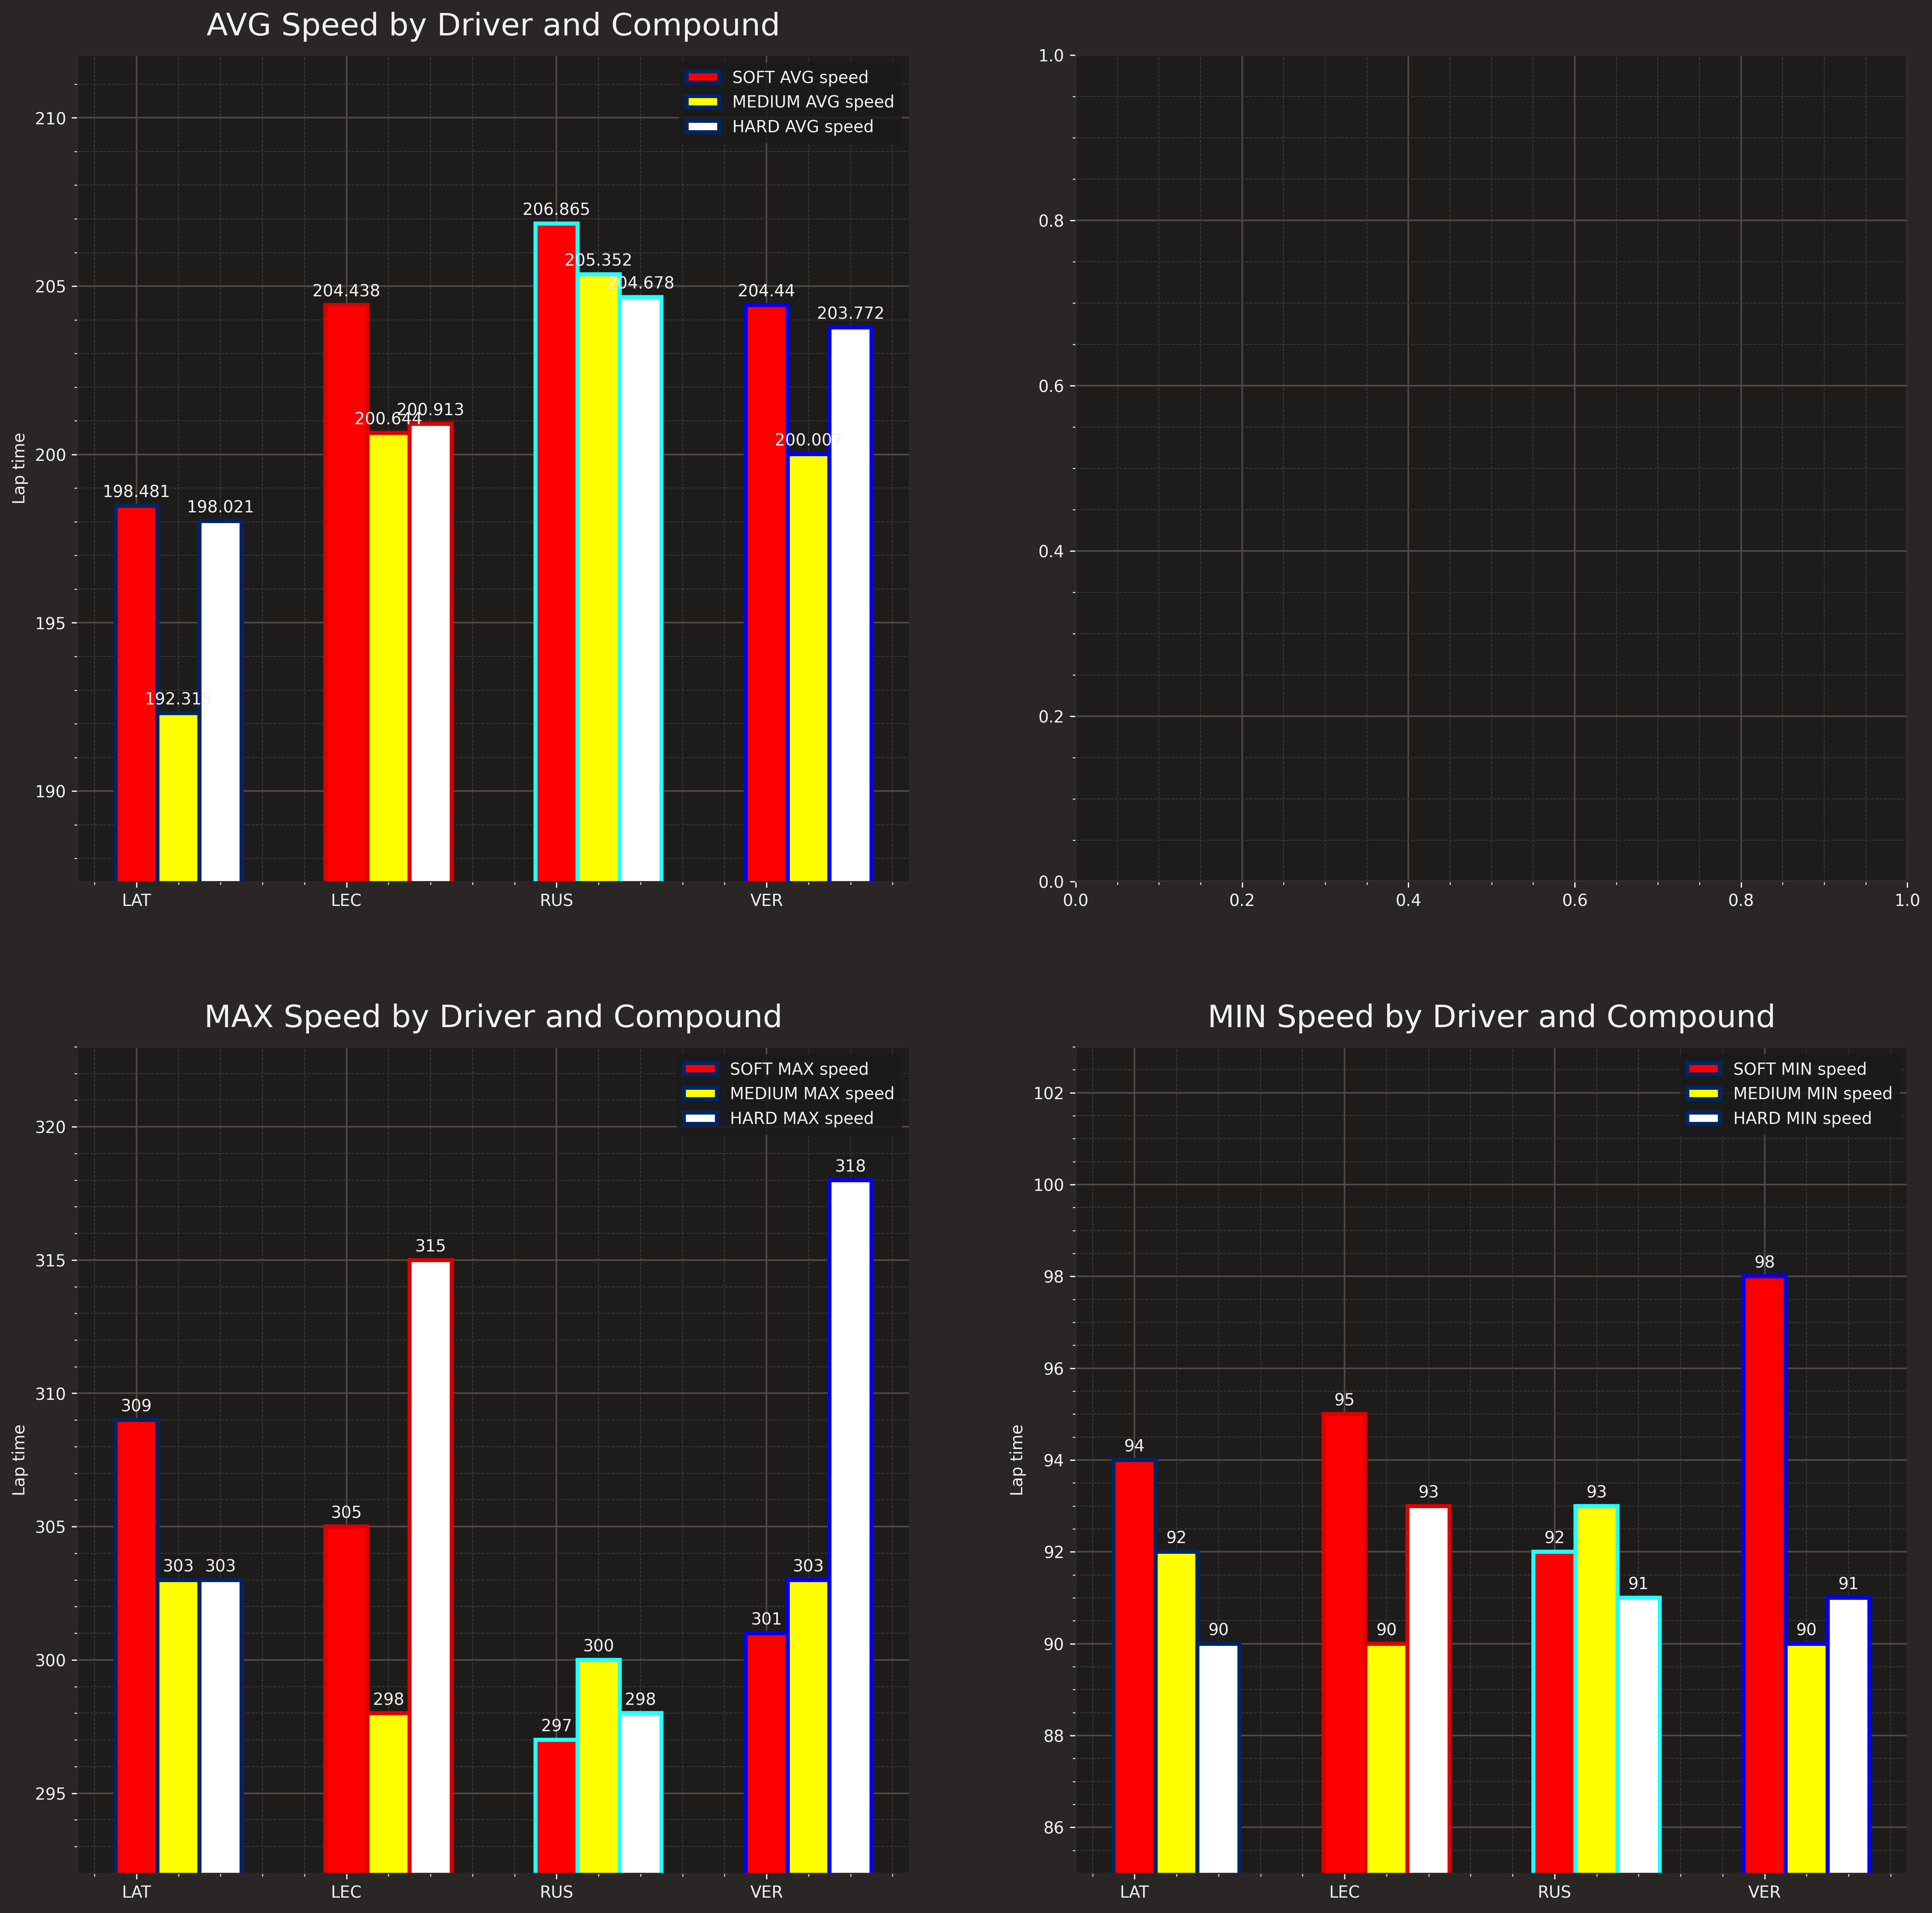

In [143]:
#fig, ((axAVG, axAVGLine), (axMIN, axMAX)) = plt.subplots(2,2)
fig, axs = plt.subplots(2,2)

fig.set_figwidth(20)
fig.set_figheight(20)

width = 0.20


plotCoordX = 0
plotCoordY = 0
for (speedTypeKey, speedType) in speeds_array.items():
    # Creating AVG Plot

    main_ticks = np.arange(speedType.groupby(["Compound"]).count()["LapTime"].max())
    currentTickType = 0
    for tyreType in tyreTypes:
        if currentTickType == 0:
            currentTicks = main_ticks
        else:
            currentTicks = [i+width for i in currentTicks]
        rects = axs[plotCoordX, plotCoordY].bar(currentTicks, np.array(speedType[speedType.Compound == tyreType]["Speed"]), width, color=tyreTypeColors[currentTickType], edgecolor=driverColors, linewidth=2.5, label=f"{tyreType} {speedTypeKey} speed")
        currentTickType = currentTickType + 1
        axs[plotCoordX, plotCoordY].bar_label(rects, padding=3)
        
    axs[plotCoordX, plotCoordY].set_ylabel('Lap time')
    axs[plotCoordX, plotCoordY].set_title(f"{speedTypeKey} Speed by Driver and Compound")

    axs[plotCoordX, plotCoordY].set_xticks(main_ticks, np.array(speedType["Driver"].unique()))
    axs[plotCoordX, plotCoordY].set_ylim([speedType["Speed"].min()-5, speedType["Speed"].max()+5])
    axs[plotCoordX, plotCoordY].legend()

    if plotCoordX == 0 and plotCoordY == 0:
        plotCoordX = 1
    elif plotCoordX == 0 and plotCoordY == 1:
        plotCoordX = 1
        plotCoordY = 0
    elif plotCoordX == 1 and plotCoordY == 0:
        plotCoordX = 1
        plotCoordY = 1
        

plt.Figure(dpi=300)
fig.set_dpi(300)
fig.savefig(f"output/MIXED_Speed_by_Tyres_{concated_names}.png", dpi=1200)
plt.show()

## AVG Speed

In [144]:

fig, ax = plt.subplots()

width = 0.20
mixed_x_ticks = np.arange(len(avg_speed))

main_ticks = np.arange(avg_speed.groupby(["Compound"]).count()["LapTime"].max())
#show(avg_speed)
currentTickType = 0
for tyreType in tyreTypes:
    if currentTickType == 0:
        currentTicks = main_ticks
    else:
        currentTicks = [i+width for i in currentTicks]
    rects = ax.bar(currentTicks, np.array(avg_speed[avg_speed.Compound == tyreType]["Speed"]), width, color=tyreTypeColors[currentTickType], edgecolor=driverColors, linewidth=2.5, label=f"{tyreType} AVG speed")
    currentTickType = currentTickType + 1
    ax.bar_label(rects, padding=3)
    
ax.set_ylabel('Speed [Km/h]')
ax.set_xlabel('Driver')
ax.set_title('AVG Speed by Driver and Compound')

ax.set_xticks(main_ticks, np.array(avg_speed["Driver"].unique()))
ax.set_ylim([avg_speed["Speed"].min()-5, avg_speed["Speed"].max()+5])
ax.legend()

plt.Figure(dpi=1200)
fig.set_dpi(1200)
fig.set_figwidth(10)
fig.savefig(f"output/AVG_Speed_by_Tyres_{concated_names}.png", dpi=1200)
plt.show()

## Get Max speed by compund diagram

In [145]:
fig, ax = plt.subplots()

width = 0.20
mixed_x_ticks = np.arange(len(avg_speed))

main_ticks = np.arange(max_speed.groupby(["Compound"]).count()["LapTime"].max())
#show(avg_speed)
currentTickType = 0
for tyreType in tyreTypes:
    if currentTickType == 0:
        currentTicks = main_ticks
    else:
        currentTicks = [i+width for i in currentTicks]
    rects = ax.bar(currentTicks, np.array(max_speed[max_speed.Compound == tyreType]["Speed"]), width, color=tyreTypeColors[currentTickType], edgecolor=driverColors, linewidth=2.5, label=f"{tyreType} MAX speed")
    currentTickType = currentTickType + 1
    ax.bar_label(rects, padding=3)
    
ax.set_ylabel('Speed [Km/h]')
ax.set_xlabel('Driver')
ax.set_title('MAX Speed by Driver and Compound')

ax.set_xticks(main_ticks, np.array(max_speed["Driver"].unique()))
ax.set_ylim([max_speed["Speed"].min()-5, max_speed["Speed"].max()+5])
ax.legend()

plt.Figure(dpi=1200)
fig.set_dpi(1200)
fig.set_figwidth(10)
fig.savefig(f"output/MAX_Speed_by_Tyres_{concated_names}.png", dpi=1200)
plt.show()

## Min speed

In [146]:
fig, ax = plt.subplots()

width = 0.20
mixed_x_ticks = np.arange(len(avg_speed))

main_ticks = np.arange(min_speed.groupby(["Compound"]).count()["LapTime"].max())
#show(avg_speed)
currentTickType = 0
for tyreType in tyreTypes:
    if currentTickType == 0:
        currentTicks = main_ticks
    else:
        currentTicks = [i+width for i in currentTicks]
    rects = ax.bar(currentTicks, np.array(min_speed[min_speed.Compound == tyreType]["Speed"]), width, color=tyreTypeColors[currentTickType], edgecolor=driverColors, linewidth=2.5, label=f"{tyreType} MIN speed")
    currentTickType = currentTickType + 1
    ax.bar_label(rects, padding=3)
    
ax.set_ylabel('Speed [Km/h]')
ax.set_xlabel('Driver')
ax.set_title('MIN Speed by Driver and Compound')

ax.set_xticks(main_ticks, np.array(min_speed["Driver"].unique()))
ax.set_ylim([min_speed["Speed"].min()-5, min_speed["Speed"].max()+5])
ax.legend()

plt.Figure(dpi=1200)
fig.set_dpi(1200)
fig.set_figwidth(10)
fig.savefig(f"output/MIN_Speed_by_Tyres_{concated_names}.png", dpi=1200)
plt.show()

# Fatest lap, speed by time


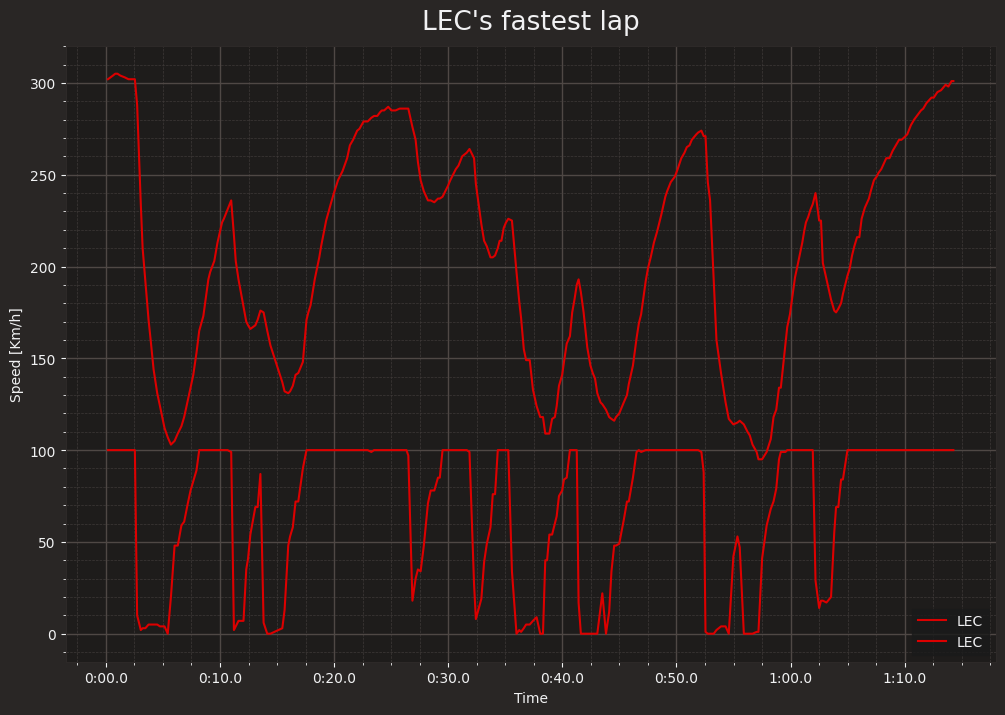

In [147]:
driverNameFast = 'LEC'

driver_color = ff1.plotting.driver_color(driverNameFast)

fastest_lap = session.laps.pick_driver(driverNameFast).pick_fastest()
car_data = fastest_lap.get_car_data()
t = car_data['Time']
velocity = car_data['Speed']
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, velocity, label=fastest_lap.Driver, color=driver_color)

ax.plot(t, car_data["Throttle"], label=fastest_lap.Driver, color=driver_color)

ax.set_xlabel('Time')
ax.set_ylabel('Speed [Km/h]')
ax.set_title(f"{fastest_lap.Driver}'s fastest lap")
ax.legend()

# Safetycar throttle


455
455
[1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1

ValueError: colors and positions are unequal sized sequences

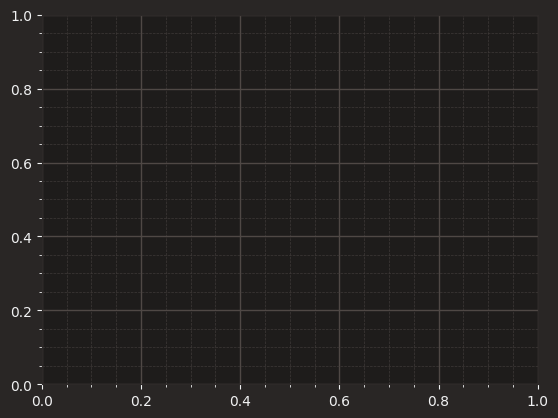

In [148]:
lec = session.laps.pick_driver('LEC')[session.laps.pick_driver('LEC')["LapNumber"] == 59]

lec_tel = lec.get_car_data().add_distance()

fer_color = ff1.plotting.team_color('FER')

status = []
colorss = []
#for lap in lec.iterlaps():
i = 0
for lap in lec_tel.itertuples():
    if lap.Throttle == 0 and lap.Brake == False:
        status.append(0)
        colorss.append("#333")
    elif lap.Throttle > 0:
        status.append(1)
        colorss.append("#00ff00")
    elif lap.Brake == True:
        status.append(2)
        colorss.append("#ff0000")
    else:
        status.append(0)
        colorss.append("#333")
    i = i + 1

print(i)
print(len(colorss))
print(status)

fig, ax = plt.subplots()

ax.eventplot(lec_tel['Distance'], colors=colorss)
ax.legend()
plt.show()

""" fig, ax = plt.subplots()
ax.plot(lec_tel['Distance'], lec_tel['Speed'], color=fer_color, label='Speed')
ax.plot(lec_tel['Distance'], lec_tel['Throttle'], "--", color=fer_color, label='Throttle')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Gear')

twin = ax.twinx()
twin.plot(lec_tel['Distance'], lec_tel['nGear'], '--', color='white')
twin.plot(ver_tel['Distance'], ver_tel['nGear'], '--', color='yellow')
twin.plot(rus_tel['Distance'], rus_tel['nGear'], '--', color='cyan')
twin.set_ylabel("Gear")

ax.legend()
plt.Figure(dpi=1200)
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")
plt.show()
 """